In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import json

from segmentation_paper_results_methods import compute_mask_metrics, get_features, \
                                               get_feature_array, cross_validate, \
                                               cross_validate_filtering_results, \
                                               cross_validate_baseline_filtering_results

pd.set_option('display.precision', 4)
np.set_printoptions(precision=2)

In [2]:
# Define path to annotations and parameters for analysis
dataset_path = "../../segmentation_masks_data/AUTOMATIC_20250305/"
prompt_method = 'Automatic'  # used in plot titles
classes = ['fish', 'bad', 'head', 'double']  # class names in annotations
display_classes = ['Fish', 'Incorrect', 'Head', 'Multiple']  # class names in figures
colors = {'fish': 'blue', 'bad': 'red', 'head': 'yellow', 'double': 'purple'}  # for visualization
rs = 43  # random seed
BASELINE_FILTER_MIN = 1000
BASELINE_FILTER_MAX = 25000
path = dataset_path
os.listdir(path)

['instances_default.json']

In [3]:
# Images data
imgs_path = "../../segmentation_masks_data/images/"
imgs = os.listdir(imgs_path)
imgs = [i.split('.png')[0] for i in imgs]

cam2 = [i for i in imgs if (i.startswith('camera2') or i.startswith('vlc'))]
cam3 = [i for i in imgs if i.startswith('camera3')]
top = [i for i in imgs if i.startswith('top')]
bottom = [i for i in imgs if i.startswith('bottom')]

print(len(cam2), len(cam3), len(top), len(bottom), len(imgs))

37 29 15 7 88


In [4]:
# Read annotations from the .json file, coco format expected
for file in os.listdir(path):
    if not file.endswith('.json'):
        continue
    f = open(path + file)
    all_data = json.load(f)
    print(all_data.keys())
    print(all_data['images'][0])
    print(all_data['annotations'][0])

    img_files = pd.DataFrame(all_data['images'])
    
    for a in all_data['annotations']:
        masks = a['segmentation']['counts']
        a['segmentation'] = masks
        a['category_name'] = all_data['categories'][a['category_id']-1]['name']
        file_name = img_files[img_files['id'] == a['image_id']]['file_name'].values[0]
        a['file_name'] = file_name
        a['camera'] = file_name.split('_')[0]

df = pd.DataFrame(all_data['annotations'])

# Results for only one camera 
#df = df[((df['camera'] == 'bottom') | (df['camera'] == 'top'))]

# Sanity check print
df.head()

dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])
{'id': 1, 'width': 2000, 'height': 1159, 'file_name': 'bottom_2022-4-24_02-18-00_002200.png', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}
{'id': 1, 'image_id': 1, 'category_id': 1, 'segmentation': {'counts': [666811, 4, 1154, 7, 1152, 9, 1149, 12, 1147, 13, 1146, 14, 1144, 16, 1143, 16, 1143, 15, 1143, 16, 1143, 16, 1143, 15, 1143, 16, 1143, 16, 1142, 16, 1143, 16, 1143, 16, 1143, 15, 1144, 15, 1144, 14, 1144, 15, 1144, 14, 1145, 14, 1145, 13, 1145, 13, 1146, 13, 1146, 12, 1147, 11, 1148, 11, 1147, 11, 1148, 11, 1148, 11, 1148, 10, 1148, 11, 1148, 11, 1148, 11, 1147, 12, 1147, 11, 1147, 12, 1147, 12, 1147, 12, 1146, 13, 1146, 13, 1145, 13, 1146, 13, 1146, 13, 1145, 14, 1145, 14, 1144, 15, 1144, 15, 1144, 15, 1143, 16, 1143, 16, 1142, 17, 1142, 17, 1142, 17, 1141, 18, 1141, 18, 1141, 18, 1141, 18, 1140, 19, 1140, 19, 1140, 19, 1140, 19, 1139, 20, 1139, 20, 1139, 20, 1138, 21, 1138, 21, 1137, 2

,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes,category_name,file_name,camera
0,1,1,1,"[666811, 4, 1154, 7, 1152, 9, 1149, 12, 1147, ...",7319.0,"[575.0, 357.0, 290.0, 44.0]",1,{'occluded': False},fish,bottom_2022-4-24_02-18-00_002200.png,bottom
1,2,1,1,"[481247, 3, 1156, 5, 1153, 7, 1152, 7, 1152, 7...",7870.0,"[415.0, 182.0, 282.0, 86.0]",1,{'occluded': False},fish,bottom_2022-4-24_02-18-00_002200.png,bottom
2,3,1,4,"[749217, 2, 1155, 5, 1151, 9, 1148, 12, 1145, ...",3093.0,"[646.0, 449.0, 97.0, 61.0]",1,{'occluded': False},head,bottom_2022-4-24_02-18-00_002200.png,bottom
3,4,1,2,"[59572, 7, 1150, 13, 1145, 15, 1143, 17, 1142,...",496.0,"[51.0, 457.0, 26.0, 24.0]",1,{'occluded': False},bad,bottom_2022-4-24_02-18-00_002200.png,bottom
4,5,1,1,"[274448, 2, 1155, 6, 1152, 7, 1150, 10, 1148, ...",6252.0,"[236.0, 911.0, 197.0, 156.0]",1,{'occluded': False},fish,bottom_2022-4-24_02-18-00_002200.png,bottom


In [5]:
# N
df.count()

id               6376
image_id         6376
category_id      6376
segmentation     6376
area             6376
bbox             6376
iscrowd          6376
attributes       6376
category_name    6376
file_name        6376
camera           6376
dtype: int64

In [6]:
# true class count of whole dataset before any processing
df.groupby(['category_name']).count()

,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes,file_name,camera
category_name,,,,,,,,,,
bad,1278,1278,1278,1278,1278,1278,1278,1278,1278,1278
double,1242,1242,1242,1242,1242,1242,1242,1242,1242,1242
fish,3182,3182,3182,3182,3182,3182,3182,3182,3182,3182
head,674,674,674,674,674,674,674,674,674,674


In [7]:
# true class distribution of whole dataset before any processing
df.groupby(['category_name'])['iscrowd'].count() / df['iscrowd'].count()

category_name
bad       0.2004
double    0.1948
fish      0.4991
head      0.1057
Name: iscrowd, dtype: float64

In [8]:
# Compute mask features
mask_metrics = compute_mask_metrics(imgs, imgs_path, df, img_files)
features = get_features(mask_metrics, classes)
X, y = get_feature_array(features)

too few points in hull to fit ellipse ../../segmentation_masks_data/images/top_2022-4-28_02-18-00_002600.png
too few points in hull to fit ellipse ../../segmentation_masks_data/images/camera3_2022-06-23_16-04-55_002500.png
too few points in hull to fit ellipse ../../segmentation_masks_data/images/top_2022-6-1_11-18-00_002000.png
too few points in hull to fit ellipse ../../segmentation_masks_data/images/camera3_2022-06-25_05-03-23_002500.png
too few points in hull to fit ellipse ../../segmentation_masks_data/images/camera3_2022-06-17_16-03-11_002000.png


[3182, 1123, 674, 1242]


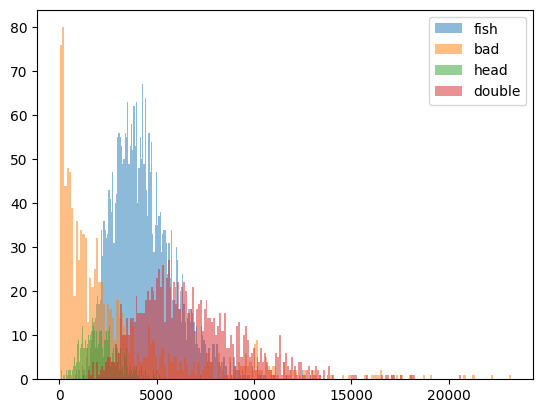

Class
fish      3182
double    1242
bad       1123
head       674
Name: count, dtype: int64
category


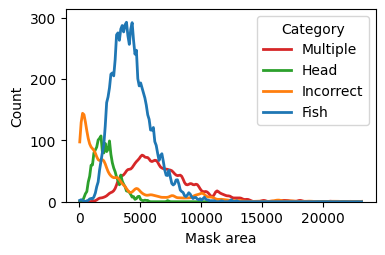

In [42]:
# Area KDE over histogram

maj_all, min_all, areas_all, n_cont_all, n_conv_all, moms_all  = mask_metrics
display_classes = ['fish', 'bad', 'head', 'double']

hist_data = [
    areas_all['fish'],
    [a for a in areas_all['bad'] if a < BASELINE_FILTER_MAX],
    areas_all['head'],
    areas_all['double']
]
print([len(h) for h in hist_data])

# Correct histogram
for h in hist_data:
    plt.hist(h, alpha=0.5, bins=200)
plt.legend(display_classes)
plt.show()

areas_tuples = []
for cat, clss_data in zip(display_classes, hist_data):
    areas_tuples.extend([(cat, a) for a in clss_data])

df_area_plot = pd.DataFrame(areas_tuples, columns=['Class', 'Mask area'])
df_area_plot['Class'] = pd.Categorical(df_area_plot['Class'], categories=display_classes, ordered=True)

# Check data
print(df_area_plot['Class'].value_counts())
print(df_area_plot['Class'].dtype)

palette = dict(zip(display_classes, sns.color_palette("tab10", len(display_classes))))

plt.figure(figsize=(4, 2.5))
sns.histplot(
    data=df_area_plot,
    x='Mask area',
    hue=df_area_plot['Class'].astype(pd.CategoricalDtype(categories=display_classes, ordered=True)),
    palette=palette,
    kde=True,
    kde_kws={'bw_adjust': 0.25},
    fill=False,
    line_kws={'lw': 2},
    alpha=0,
    hue_order=display_classes)

# NB: Different ordering explicitly on purpose, for some reason seaborn cannot handle 
# the ordering correctly. This is the correct ordering on MY MACHINE. 
# Check the correct plt plot above to verify.
plt.legend(
    title='Category',
    labels=['Multiple', 'Head', 'Incorrect', 'Fish'],  
    loc='upper right'
)

plt.show()

0.9942501735932361
  Class  2nd Hu moment invariant
0  fish                   0.3162
1  fish                   0.6577
2  fish                   0.2100
3  fish                   0.2921
4  fish                   0.1455


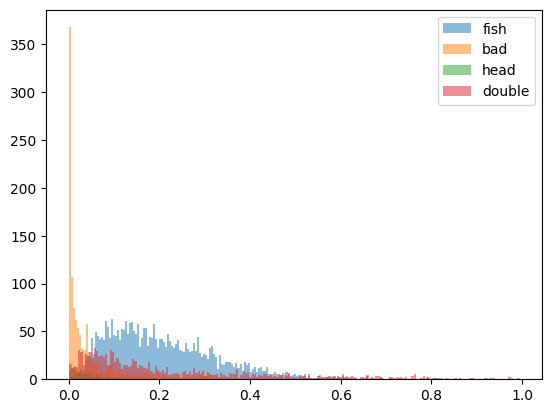

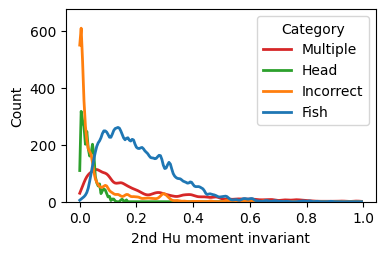

In [44]:
# Maj KDE over histogram

maj_all, min_all, areas_all, n_cont_all, n_conv_all, moms_all  = mask_metrics

hist_data = [
    moms_all['fish'],
    moms_all['bad'],
    moms_all['head'],
    moms_all['double']
]

mom_tuples = []
for cat, clss_data in zip(display_classes, hist_data):
    mom_tuples.extend([(cat, a[1]) for a in clss_data if a[1] < 1])

df_mom_plot = pd.DataFrame(mom_tuples, columns=['Class', '2nd Hu moment invariant'])

print(df_mom_plot['2nd Hu moment invariant'].max())
print(df_mom_plot.head())

# Correct histogram
for d in display_classes:
    plt.hist(df_mom_plot[df_mom_plot['Class'] == d]['2nd Hu moment invariant'].values, alpha=0.5, bins=200)
plt.legend(display_classes)
plt.show()

df_mom_plot['Class'] = pd.Categorical(df_mom_plot['Class'], categories=display_classes)

plt.figure(figsize=(4, 2.5))
sns.histplot(
    data=df_mom_plot,
    x='2nd Hu moment invariant',
    hue='Class',
    kde=True,
    kde_kws={'bw_adjust': 0.25},
    fill=False,
    line_kws={'lw': 2},
    alpha=0)

# NB: Different ordering explicitly on purpose, for some reason seaborn cannot handle 
# the ordering correctly. This is the correct ordering on MY MACHINE. 
# Check the correct plt plot above to verify.
plt.legend(
    title='Category',
    labels=['Multiple', 'Head', 'Incorrect', 'Fish'],
    loc='upper right'
)

plt.show()

In [ ]:
# Baseline filtering results for the whole dataset
filtered_masks = []
for i, seg in df.iterrows():
    if (seg['area'] < BASELINE_FILTER_MAX) and (seg['area'] > BASELINE_FILTER_MIN):
        filtered_masks.append(seg)

baseline_filtered_df = pd.DataFrame(filtered_masks)
print('N', baseline_filtered_df['iscrowd'].count())
print('Distribution of classes \n', \
      baseline_filtered_df.groupby(['category_name'])['iscrowd'].count() / baseline_filtered_df['iscrowd'].count())

In [ ]:
baseline_filtered_df.groupby(['category_name'])['iscrowd'].count() 

In [ ]:
cross_validate(X, y, 0, rs, classes)

In [ ]:
cross_validate(X, y, 1, rs, classes)

In [ ]:
cross_validate(X, y, 2, rs, classes)

In [ ]:
cross_validate(X, y, 3, rs, classes)

In [ ]:
# Cross-validated baseline filtering performance: SIZE ONLY
scores_f, scores_fh, scores_fhm = cross_validate_baseline_filtering_results(df, rs, BASELINE_FILTER_MAX, BASELINE_FILTER_MIN)

print('Fish %, mean and std: ', "{:.3f}".format(np.mean(scores_f)), "{:.3f}".format(np.std(scores_f)))
print('Fish+head %, mean and std: ', "{:.3f}".format(np.mean(scores_fh)), "{:.3f}".format(np.std(scores_fh)))
print('Fish+head+multiple %, mean and std: ', "{:.3f}".format(np.mean(scores_fhm)), "{:.3f}".format(np.std(scores_fhm)))

In [ ]:
# Cross-validated baseline filtering performance of the RF classifier
scores_f, scores_fh, scores_fhm = cross_validate_filtering_results(X, y, rs, prompt_method)
print('Fish %, mean and std: ', "{:.3f}".format(np.mean(scores_f)), "{:.3f}".format(np.std(scores_f)))
print('Fish+head %, mean and std: ', "{:.3f}".format(np.mean(scores_fh)), "{:.3f}".format(np.std(scores_fh)))
print('Fish+head+multiple %, mean and std: ', "{:.3f}".format(np.mean(scores_fhm)), "{:.3f}".format(np.std(scores_fhm)))

